In [1]:
import textract
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import string
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=2)
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

import gc
import warnings
warnings.filterwarnings("ignore")

import utils_read_pdf
import utils
import utils_summary

In [2]:
STOP_WORDS = stopwords.words('english')
SOURCE_FOLDER = 'Source_data/'

In [3]:
sources = pd.read_excel(SOURCE_FOLDER + 'Sources.xlsx')
sources.head()

,status,name,label,code_name,type
0,1,KSA Vision 2030. Strategic Objectives and Visi...,1,"'1.pdf' ,",presentation
1,1,National Transformation Program 2020.Kingdom o...,2,"'2.pdf' ,",presentation
2,1,Medium-Term Strategic Framework (MTSF). 2014-2...,3,"'3.pdf' ,",text
3,1,Appendixes 1-14 toMedium-Term Strategic Framew...,4,"'4.pdf' ,",text
4,0,Eleventh Malaysia Plan. Strategy Paper 5. Achi...,5,"'5.pdf' ,",text


In [4]:
filenames = ['1', '2', '3', '4', '7', '8', '9', '10', \
             '12', '15', '16', '17', '18', '19', '20', \
             '21', '22', '23', '24', '25']
# filenames = ['1', '2', '3', '4', '21', '22', '23', '24', '25']

In [5]:
articles = utils_read_pdf.read_pdf(SOURCE_FOLDER, filenames)

100%|██████████| 20/20 [10:37<00:00, 31.88s/it]


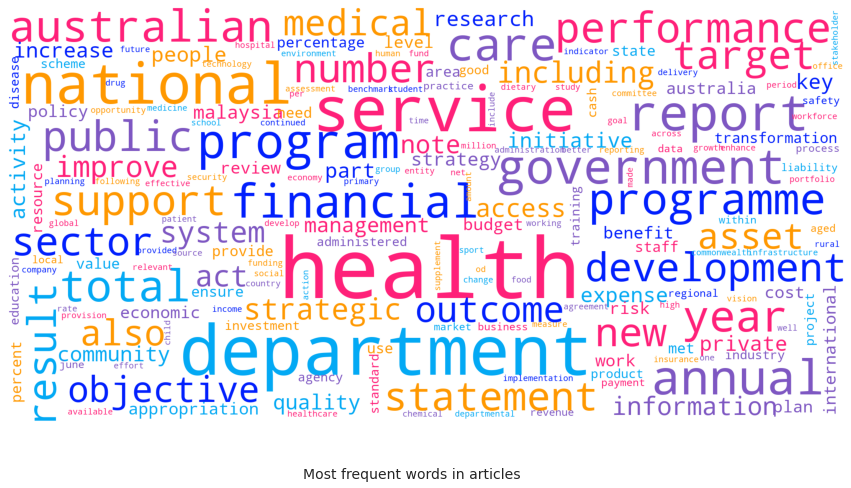

2071

In [6]:
word_tokens = utils.word_tokenize([text for text in articles])
# word_tokens
word_freqs = pd.Series(word_tokens).value_counts()
utils.wordcloud(word_freqs, "Most frequent words in articles")
del word_tokens, word_freqs
gc.collect()

In [7]:
# Токенизация всех статей (list of lists)
tokens = [utils.word_tokenize(article) for article in articles]

### TOPIC MODELLING И РЕКОМЕНДАЦИЯ СТАТЕЙ

In [9]:
''' ДЛЯ КАЖДОГО ДОКУМЕНТА СОЗДАЁТСЯ 
    corpus[:1][0] = (0, 1) - СЛОВО С ИНДЕКСОМ 0 (id2word[0] = 'addition') 
                             ВСТРЕЧАЕТСЯ В ТЕКСТЕ
                             corpus[:1] 1 РАЗ 
    ЭТО ВХОД ДЛЯ LDA '''

data_lemmatized = utils.lemmatize(tokens)

id2word = corpora.Dictionary(data_lemmatized) # словарь

corpus_word_freq = [id2word.doc2bow(text) for text in data_lemmatized]

# ''' КОРПУС ПЕРВОГО ТЕКСТА В ЧЕЛОВЕКО-ЧИТАЕМОМ ВИДЕ '''

# [[(id2word[id], freq) for id, freq in cp] for cp in corpus_word_freq[ : 1]][0][:5]

### ПУСК LDA

In [10]:
''' num_topics - КОЛ-ВО ТЕМ, ИСКОМОЕ
    alpha - ПАРАМЕТР РАСПРЕДЕЛЕНИЯ ДИРИХЛЕ ДЛЯ ТЕМ, ИСКОМОЕ
    eta - ПАРАМЕТР РАСПРЕДЕЛЕНИЯ ДИРИХЛЕ ДЛЯ СЛОВ, ИСКОМОЕ
    
    id2word - Mapping from word IDs to words
    
    update_every - КОЛ-ВО ДОКУМЕНТОВ НА ОБНОВЛЕНИЕ, 
                   ЕСЛИ = 0, ТО ПАКЕТНОЕ ОБУЧЕНИЕ
                   ЕСЛИ > 1, ОНЛАЙН ОБУЧЕНИЕ
                   
    chunksize - Number of documents to be used in each training chunk
    
    passes - Number of passes through the corpus during training
    
    per_word_topics (bool) – If True, the model also computes 
                             a list of topics, sorted in descending order 
                             of most likely topics for each word, along with 
                             their phi values multiplied by the feature length 
                             (i.e. word count).'''


LDA = gensim.models.ldamodel.LdaModel(corpus = corpus_word_freq, 
                                      id2word = id2word, 
                                      num_topics = 8, 
                                      alpha = 'auto', 
                                      eta = 'auto', 
                                      
                                      random_state = 42, 
                                      update_every = 1, 
                                      chunksize = 100, 
                                      passes = 10, 
                                      per_word_topics = True)

topics = LDA.print_topics()

for topic in topics:
    print ('')
    print (topic)


(0, '0.015*"rm" + 0.011*"dan" + 0.010*"growth" + 0.008*"gdp" + 0.006*"mp" + 0.006*"malaysia" + 0.006*"per" + 0.005*"thrust" + 0.005*"economic" + 0.005*"household"')

(1, '0.011*"malaysia" + 0.009*"programme" + 0.008*"national" + 0.006*"transformation" + 0.006*"service" + 0.005*"also" + 0.005*"report" + 0.005*"percent" + 0.005*"year" + 0.005*"annual"')

(2, '0.002*"department" + 0.002*"health" + 0.002*"service" + 0.001*"support" + 0.001*"violence" + 0.001*"family" + 0.001*"child" + 0.001*"report" + 0.001*"injury" + 0.001*"national"')

(3, '0.025*"health" + 0.020*"department" + 0.011*"service" + 0.008*"report" + 0.008*"financial" + 0.008*"annual" + 0.008*"australian" + 0.008*"statement" + 0.007*"total" + 0.007*"care"')

(4, '0.024*"objective" + 0.021*"benchmark" + 0.021*"percentage" + 0.014*"performance" + 0.014*"strategic" + 0.014*"sector" + 0.013*"vision" + 0.013*"applicable" + 0.012*"target" + 0.012*"national"')

(5, '0.016*"health" + 0.010*"od" + 0.010*"research" + 0.009*"supplement

In [11]:
print('Perplexity: ', LDA.log_perplexity(corpus_word_freq))

coherence_model_lda = CoherenceModel(model = LDA, \
                                     texts=data_lemmatized, \
                                     dictionary=id2word, \
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Perplexity:  -7.420658957042016
Coherence Score:  0.5044475169539706


In [12]:
''' ВИЗУАЛИЗАЦИЯ '''

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(LDA, corpus_word_freq, id2word)

pyLDAvis.show(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [10/Nov/2020 14:44:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2020 14:44:56] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2020 14:44:56] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2020 14:44:56] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2020 14:44:56] code 404, message Not Found
127.0.0.1 - - [10/Nov/2020 14:44:56] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


### ГЛАВНАЯ ТЕМА ДОКУМЕНТА

In [13]:
df_dominant_topic = utils.dominant_topic(ldamodel = LDA, \
                                   corpus = corpus_word_freq, \
                                   sources = sources, 
                                   filenames = filenames)

''' ДОКУМЕНТЫ, В КОТОРЫХ Perc_Contribution != 100% 
    ИМЕЕТСЯ МИКС ИЗ НЕСКОЛЬКИХ ТЕМ С РАЗНОЙ МАССОЙ'''

df_dominant_topic

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Article
0,7.0,0.8930,"government, service, economy, sector, economic...",KSA Vision 2030. Strategic Objectives and Visi...
1,4.0,1.0000,"objective, benchmark, percentage, performance,...",National Transformation Program 2020.Kingdom o...
2,7.0,1.0000,"government, service, economy, sector, economic...",Medium-Term Strategic Framework (MTSF). 2014-2...
3,7.0,1.0000,"government, service, economy, sector, economic...",Appendixes 1-14 toMedium-Term Strategic Framew...
4,1.0,1.0000,"malaysia, programme, national, transformation,...",NTP (National Transformation Programme). Annua...
5,0.0,0.9999,"rm, dan, growth, gdp, mp, malaysia, per, thrus...","Eleventh Malaysia Plan 2016-2020. Малайзия, Ec..."
6,3.0,1.0000,"health, department, service, report, financial...","Australian Government, Department of Health. A..."
7,3.0,1.0000,"health, department, service, report, financial...","Australian Government, Department of Health. A..."
8,6.0,1.0000,"security, mission, strategic, dhs, goal, plan,...","U.S. Department of HHS. Strategic Plan, Fiscal..."
9,5.0,0.9889,"health, od, research, supplement, dietary, pro...",Strategic Plan FY 2018 — 2022_Strategic Goal 1...


# Библиотека статей

In [14]:
for i in df_dominant_topic.index:
    print(i+1)
    print(df_dominant_topic.Article[i])
    print('Ключевые слова: ', df_dominant_topic.Topic_Keywords[i])

1
KSA Vision 2030. Strategic Objectives and Vision Realization Programs. Kingdom of Saudi Arabia (KSA) , 79 р.
Ключевые слова:  government, service, economy, sector, economic, development, public, objective, program, social
2
National Transformation Program 2020.Kingdom of Saudi Arabia (KSA), 57 р., 2016. 
Ключевые слова:  objective, benchmark, percentage, performance, strategic, sector, vision, applicable, target, national
3
Medium-Term Strategic Framework (MTSF). 2014-2019, Republic of South Africa, 36 р. 2014. 
Ключевые слова:  government, service, economy, sector, economic, development, public, objective, program, social
4
Appendixes 1-14 toMedium-Term Strategic Framework (MTSF). 2014-2019, Republic of South Africa,310 р., 2014. 
Ключевые слова:  government, service, economy, sector, economic, development, public, objective, program, social
5
NTP (National Transformation Programme). Annual Report 2015. Малайзия,  Office of the Advisor to the Prime Minister, PEMANDU, 2016, 292р. 
Кл

# Выбор статьи

In [15]:
print('Введите индекс интересующей статьи\n')
try:
    idx = int(input())
    print('ВЫБРАННАЯ СТАТЬЯ: ', df_dominant_topic.Article[idx-1])
except ValueError:
      print("Такого индекса нет.")

Введите индекс интересующей статьи

15
ВЫБРАННАЯ СТАТЬЯ:  Strategic_Plan_2010-2014_Progress_Report


# Рекомендация на основе доминирующей темы

In [16]:
dominant_topic = df_dominant_topic.loc[df_dominant_topic.index == idx-1, 'Dominant_Topic'].values[0]
recommend_art_idx = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == dominant_topic].index
print('РЕКОМЕНДАЦИИ: ')

# print(df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == dominant_topic, 'Article'])

for i in recommend_art_idx:
    if i != idx-1:
        
#         print(sources.loc[sources.label == int(filenames[i]), 'type'].values[0])
#         print('№', filenames[i])
#         print(sources.loc[sources.label == int(filenames[i]), 'name'].values[0])
        print('\n', df_dominant_topic.loc[i, 'Article'])
        text =  utils_read_pdf.clean_pdf(articles[i])
        
        if sources.loc[sources.label == int(filenames[i]), 'type'].values[0] != 'presentation':
           
            sent_text = utils_summary.show_summary(text)
            print('\nВведите номер интересующего предложения, чтобы увидеть контекст\n' + 
               'или нажмите Enter, чтобы выйти.\n')
            sent_id = input()
            utils_summary.show_context(sent_id, sent_text)
            
        else:
            print('Это презентация')
            utils_summary.show_key_ph(text)
        print('==|==|==')
            

РЕКОМЕНДАЦИИ: 

 Strategic Plan FY 2018 — 2022_Strategic Goal 1 _ HHS.gov

Ключевые фразы:
--medicare health care--
--healthcare costs--
--healthcare services--
--healthcare spending--
--healthcare quality--

Ключевые предложения:
51 :  Performance Goals  Reduce the average out-of-pocket share of prescription drug costs while in the Medicare Part D Prescription Drug Benefit coverage gap for nonLow-Income Subsidy Medicare beneficiaries who reach the gap and have no supplemental coverage in the gap  Increase the percentage of Medicare health care dollars tied to Alternate Payment Models incorporating downside risk    Back to top    Strategic Objective 1.2: Expand safe, high-quality healthcare options, and encourage innovation and competition Strengthening the Nations healthcare system cannot be achieved without improving healthcare quality and safety for all Americans.
33 :  HHS is committed to lowering healthcare costs for Americans to affordable levels and minimizing the burden of gove


==|==|==

 Strategic Plan FY 2018 — 2022_Strategic Goal 4 _ HHS.gov

Ключевые фразы:
--public health surveillance data--
--public health--
--public health threats--
--high-impact public health interventions--
--public health emergencies--

Ключевые предложения:
17 :  Identifying and mitigating urgent and persistent threats to public health depends on the quality of surveillance, epidemiology, and laboratory servicesat the Federal, State, and local levels as well as with U.S. territories, Tribes, and international partners.
14 :  Back to top    Strategic Objective 4.1: Improve surveillance, epidemiology, and laboratory services In an increasingly interconnected world, public health threats can quickly escalate from an isolated incident to a regional or even global emergency.
51 :  The Department is developing the knowledge to support evidence-based interventions for public health emergencies through the following strategies:  Enhance the portfolio of strategies, interventions, and eval